In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
import my_modules.sofa as sofa

In [2]:
# Load Tx data
dir = "DB_EXP_3x16Gbaud/2x16QAM_16GBd.csv"
tx = np.loadtxt(dir, delimiter=",", skiprows=1)
tx_c = tx[:, 0] + 1j * tx[:, 1]

In [3]:
# Create spectral spacing dictionary
spacing = {
    "single_ch":    [14.3, 15.3, 16.3, 17.8, 19.3, 21.3, 23.3, 26.3, 28.3, 31.3, 36.3],
    "18GHz":        [18, 19, 20, 23, 25, 27, 30, 32, 35, 40],
    "17.6GHz":      [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "17GHz":        [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "16.5GHz":      [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "16GHz":        [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "15.5GHz":      [20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "15GHz":        [23, 25, 27, 30, 32, 35, 40]
}

X = []
y = []

# Load Rx data
sp = "17GHz"
dir = f"DB_EXP_3x16Gbaud/{sp}/"
cont = 0
for i in spacing[sp]:
    rx = np.loadtxt(dir + f"16QAM_3x16GBd_consY{i}dB.csv", delimiter=",", skiprows=1)
    rx_c = rx[:, 0] + 1j * rx[:, 1]

    # Sync Tx and Rx
    y_aux = sofa.synchronize_signals(tx_c, rx_c)

    # Add to X and y lists
    y.append(y_aux)
    X.append(rx)

    # show the progress
    cont += 1
    print(f"Iteration {cont} of {len(spacing[sp])} done")

X = np.array(X)
y = np.array(y)

Iteration 1 of 11 done
Iteration 2 of 11 done
Iteration 3 of 11 done
Iteration 4 of 11 done
Iteration 5 of 11 done
Iteration 6 of 11 done
Iteration 7 of 11 done
Iteration 8 of 11 done
Iteration 9 of 11 done
Iteration 10 of 11 done
Iteration 11 of 11 done


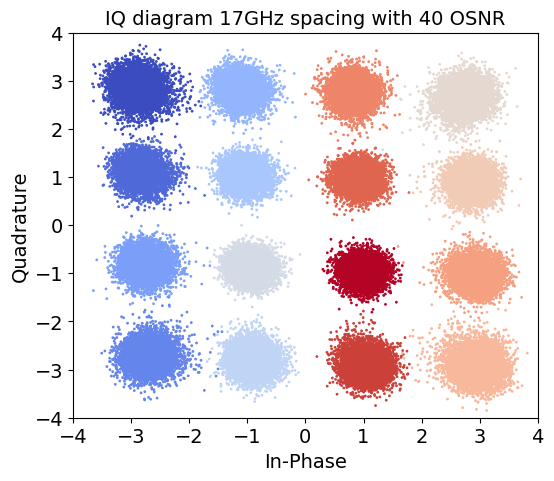

In [4]:
plt.figure(figsize=(6, 5))
plt.title(f"IQ diagram 17GHz spacing with {spacing[sp][-1]} OSNR", fontsize=14)
plt.scatter(X[-1, :, 0], X[-1, :, 1], s=1, c=y[-1], cmap="coolwarm")
plt.xlabel("In-Phase", fontsize=14)
plt.ylabel("Quadrature", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

## Conventinal Demodulation

In [5]:
ber_conv = []
cont = 0
for i in range(len(X)):
    syms_dem = sofa.demapper_sym(X[i, :, 0], X[i, :, 1])
    ber = sofa.bit_error_rate(syms_dem, y[i])
    ber_conv.append(ber)
    cont += 1
    print(f"Iteration {cont} of {len(spacing[sp])} done")

ber_conv = np.array(np.log10(ber_conv))

Iteration 1 of 11 done
Iteration 2 of 11 done
Iteration 3 of 11 done
Iteration 4 of 11 done
Iteration 5 of 11 done
Iteration 6 of 11 done
Iteration 7 of 11 done
Iteration 8 of 11 done
Iteration 9 of 11 done
Iteration 10 of 11 done
Iteration 11 of 11 done


## Demodulation using Decision Tree (DT) Algorithm

In [ ]:
# Define the hyperparameters
max_depth = [4, 5, 6, 7, 8]
min_samples_split = [20, 40, 80, 160, 320]

# Define the BER list
df = pd.DataFrame(columns=["OSNR", "Max Depth", "Min Samples Split", "log10(BER)"])

# Train the model and calculate the BER
for i in range(len(spacing[sp])):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.4, random_state=42)
    for j in max_depth:
        for k in min_samples_split:
            clf = DecisionTreeClassifier(max_depth=j, min_samples_split=k).fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            ber = sofa.bit_error_rate(y_test, y_pred)
            df.loc[len(df)] = [spacing[sp][i], j, k, np.log10(ber)]

    print(f"Iteration {i+1} of {len(spacing[sp])} done")

In [ ]:
# df.to_csv("results_DT.csv", index=False) # Uncomment to save the DataFrame

In [6]:
# Get the best BER for each OSNR
df = pd.read_csv("results_DT.csv") # Uncomment to load the DataFrame
min_ber = df.groupby('OSNR')['log10(BER)'].idxmin()

# Get the BER array
ber_dt = df.loc[min_ber, "log10(BER)"].values

# Show the table with the best BER
df.loc[min_ber]

,OSNR,Max Depth,Min Samples Split,log10(BER)
10,18.0,6.0,20.0,-1.340750
39,19.0,6.0,320.0,-1.517717
64,20.0,6.0,320.0,-1.624848
87,21.5,6.0,80.0,-2.024051
111,23.0,6.0,40.0,-2.374721
141,25.0,7.0,40.0,-2.725134
162,27.0,6.0,80.0,-3.091789
185,30.0,6.0,20.0,-3.542038
210,32.0,6.0,20.0,-3.485133
235,35.0,6.0,20.0,-3.778610


## Demodulation using Random Forest (RDF) Algorithm

In [ ]:
# Define the hyperparameters
n_estimators = [10, 50, 100, 200, 500]

# Define the BER list
df = pd.DataFrame(columns=["OSNR", "N Estimators", "log10(BER)"])

# Train the model and calculate the BER
for i in range(len(spacing[sp])):
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.4, random_state=42)
    for j in n_estimators:
        clf = RandomForestClassifier(n_estimators=j, max_depth=6, min_samples_split=20).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        ber = sofa.bit_error_rate(y_test, y_pred)
        df.loc[len(df)] = [spacing[sp][i], j, np.log10(ber)]

    print(f"Iteration {i+1} of {len(spacing[sp])} done")

In [ ]:
# df.to_csv("results_RDF.csv", index=False) # Uncomment to save the DataFrame

In [7]:
# Get the best BER for each OSNR
df = pd.read_csv("results_RDF.csv") # Uncomment to load the DataFrame
min_ber = df.groupby('OSNR')['log10(BER)'].idxmin()

# Get the BER array
ber_rdf = df.loc[min_ber, "log10(BER)"].values

# Show the table with the best BER
df.loc[min_ber]

,OSNR,N Estimators,log10(BER)
1,18.0,50.0,-1.346914
8,19.0,200.0,-1.521180
11,20.0,50.0,-1.626850
18,21.5,200.0,-2.042901
22,23.0,100.0,-2.397775
29,25.0,500.0,-2.721180
32,27.0,100.0,-3.104288
37,30.0,100.0,-3.578250
42,32.0,100.0,-3.550812
46,35.0,50.0,-3.722494


## Demodulation using DBSCAN plus K-D tree Algorithm

In [ ]:
from scipy.spatial import cKDTree

def kdtree_threshold(y_pred, Z, n_neighbors=5):
    new_labels = np.copy(y_pred)
    noise = X_test[new_labels == -1]
    noise_idx = np.where(new_labels == -1)[0]
    non_noise = X_test[new_labels != -1]
    if len(noise) == 0 or len(non_noise) == 0:
        pass
    else:
        kdtree = cKDTree(non_noise)
        _, ind = kdtree.query(noise, k=n_neighbors)
        for i in range(len(noise)):
            labels = y_pred[y_pred != -1][ind[i]]
            label = np.argmax(np.bincount(labels))
            new_labels[noise_idx[i]] = label
    
    return new_labels

In [ ]:
# Define the hyperparameters
eps = [0.1, 0.2, 0.3, 0.4]
min_samples = [300, 500, 630, 750]

# Define the BER list
df = pd.DataFrame(columns=["OSNR", "Epsilon", "Min Samples", "log10(BER)"])

# Train the model and calculate the BER
for i in range(len(spacing[sp])):
    idx = np.argsort(y[i])
    X_test = X[i][idx]
    y_test = y[i][idx]
    for j in eps:
        for k in min_samples:
            clf = DBSCAN(eps=j, min_samples=k).fit(X_test)
            y_pred = clf.labels_
            new_y_pred = kdtree_threshold(y_pred, X_test, n_neighbors=15)
            ber = sofa.bit_error_rate(y_test, new_y_pred)
            df.loc[len(df)] = [spacing[sp][i], j, k, np.log10(ber)]

    print(f"Iteration {i+1} of {len(spacing[sp])} done")

In [ ]:
df.to_csv("results_DBSCAN.csv", index=False) # Uncomment to save the DataFrame

In [8]:
# Get the best BER for each OSNR
df = pd.read_csv("results_DBSCAN.csv") # Uncomment to load the DataFrame
min_ber = df.groupby('OSNR')['log10(BER)'].idxmin()

# Get the BER array
ber_db = df.loc[min_ber, "log10(BER)"].values

# Show the table with the best BER
df.loc[min_ber]

,OSNR,Epsilon,Min Samples,log10(BER)
10,18.0,0.3,630.0,-0.599407
20,19.0,0.2,300.0,-0.497507
42,20.0,0.3,630.0,-0.587861
53,21.5,0.2,500.0,-0.999169
71,23.0,0.2,750.0,-0.892699
87,25.0,0.2,750.0,-2.744075
103,27.0,0.2,750.0,-3.140634
112,30.0,0.1,300.0,-3.355643
136,32.0,0.3,300.0,-3.589726
149,35.0,0.2,500.0,-3.525001


# Plot the Results BER vs OSNR

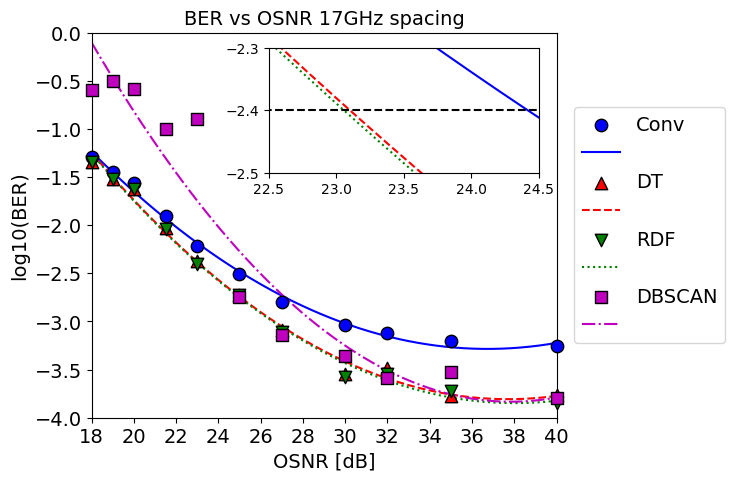

In [9]:
x_step = np.linspace(np.min(spacing[sp]), np.max(spacing[sp]), 1000)

plt.figure(figsize=(6, 5))

# Plot the BER vs OSNR
plt.scatter(spacing[sp], ber_conv, s=80, c='b', edgecolors='k', marker='o', label="Conv", zorder=10, clip_on=False)
plt.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_conv), 'b-', label=" ")

plt.scatter(spacing[sp], ber_dt, s=80, c='r', edgecolors='k', marker='^', label="DT", zorder=10, clip_on=False)
plt.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_dt), 'r--', label=" ")

plt.scatter(spacing[sp], ber_rdf, s=80, c='g', edgecolors='k', marker='v', label="RDF", zorder=10, clip_on=False)
plt.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_rdf), 'g:', label=" ")

plt.scatter(spacing[sp], ber_db, s=80, c='m', edgecolors='k', marker='s', label="DBSCAN", zorder=10, clip_on=False)
plt.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_db), 'm-.', label=" ")

plt.title(f"BER vs OSNR 17GHz spacing", fontsize=14)
plt.xlabel("OSNR [dB]", fontsize=14)
plt.ylabel("log10(BER)", fontsize=14)
plt.xticks(np.arange(np.min(spacing[sp]), np.max(spacing[sp])+1, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(np.min(spacing[sp]), np.max(spacing[sp]))
plt.ylim(-4, 0)
plt.legend(loc='center', bbox_to_anchor=(1.2, 0.5), fontsize=14)

# Plot zoomed in the best BER
ax_zoom = plt.axes([0.42, 0.6, 0.45, 0.25])
ax_zoom.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_conv), 'b-')
ax_zoom.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_dt), 'r--')
ax_zoom.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_rdf), 'g:')
ax_zoom.plot(x_step, sofa.polinomial_func(x_step, spacing[sp], ber_db), 'm-.')
ax_zoom.hlines(-2.4, np.min(spacing[sp]), np.max(spacing[sp]), colors='k', linestyles='dashed')
ax_zoom.set_xlim(22.5, 24.5)
ax_zoom.set_ylim(-2.5, -2.3)

plt.show()